In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
from glob import glob
from src import Module, DataModule, DatasetFCI, DatasetFCIm
import torch 
import torchmetrics 
from tqdm import tqdm
import os 
from skimage import io
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
checkpoints = glob('./checkpoints/*')
checkpoints

['./checkpoints/myunet-rs50-fcim-lrs-val_metric=0.68107-epoch=14.ckpt',
 './checkpoints/unetpp-rs50-fcim-lrs-val_metric=0.68205-epoch=15.ckpt']

In [4]:
name = "unetpp-rs50-fcim-lrs-val_metric=0.68205-epoch=15.ckpt"
checkpoint = f'./checkpoints/{name}'

# module = Module.load_from_checkpoint(checkpoint)

state_dict = torch.load(checkpoint, map_location='cpu')['state_dict']
module = Module({"encoder": "timm-resnest50d", "in_chans": 5, "pretrained": None, "padding": 1, "mask_loss": True, "architecture": "UnetPlusPlus"})
module.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
def median_filter(input, kernel_size):
    # Calculate padding size
    padding = kernel_size // 2
    # Pad the input tensor
    padded = torch.nn.functional.pad(input, (padding, padding, padding, padding))
    # Unfold the padded tensor into sliding local blocks
    unfolded = padded.unfold(-2, kernel_size, 1).unfold(-1, kernel_size, 1)
    # Compute the median along the extra dimension
    median = unfolded.contiguous().view(*unfolded.shape[:-2], -1).median(dim=-1).values
    # Remove padding
    median = median[..., padding:-padding]
    return median

def erode(input, kernel_size):
    # Apply max pooling, which corresponds to erosion for binary images
    return -torch.nn.functional.max_pool2d(-input, kernel_size=kernel_size, stride=1, padding=kernel_size//2)

def dilate(input, kernel_size):
    # Apply max pooling, which corresponds to dilation for binary images
    return torch.nn.functional.max_pool2d(input, kernel_size=kernel_size, stride=1, padding=kernel_size//2)

In [6]:
noise_reduction = False # no mejora prácticamente nada
erosion = False # no mejora
dilation = False # no mejora

def eval(model, device=0, mask_loss=False):
	# dm = DataModule(false_color=True, t=[4], val_trans={'Resize': {"height":384, 'width':384}})
	dm = DataModule(Dataset="DatasetFCIm")
	dm.setup()
	model.eval()
	model.cuda(device)
	metric = torchmetrics.Dice().cuda(device)
	with torch.no_grad():
		pbar = tqdm(dm.val_dataloader())
		for batch in pbar:
			x, y = batch
			if mask_loss: x = x[...,:-1]
			y_hat = model(x.cuda(device))
			y_hat = torch.sigmoid(y_hat) > 0.5
			y_hat = y_hat.float()
			if noise_reduction:
				# y_hat = torch.tensor(median_filter(y_hat.cpu().numpy(), size=3)).cuda(device)
				y_hat = median_filter(y_hat, kernel_size=3)
			if erosion:
				y_hat = erode(y_hat, kernel_size=3)
			if dilation:
				y_hat = dilate(y_hat, kernel_size=3)
			metric(y_hat, y.cuda(device).unsqueeze(1))
			pbar.set_description(f'Dice: {metric.compute().cpu().item():.5f}')

In [7]:
eval(module, mask_loss=True)

Dice: 0.68234: 100%|██████████| 36/36 [00:19<00:00,  1.89it/s]


Shape analysis

In [9]:
dm = DataModule(Dataset="DatasetFCIm", val_size=0, batch_size=25)
dm.setup()

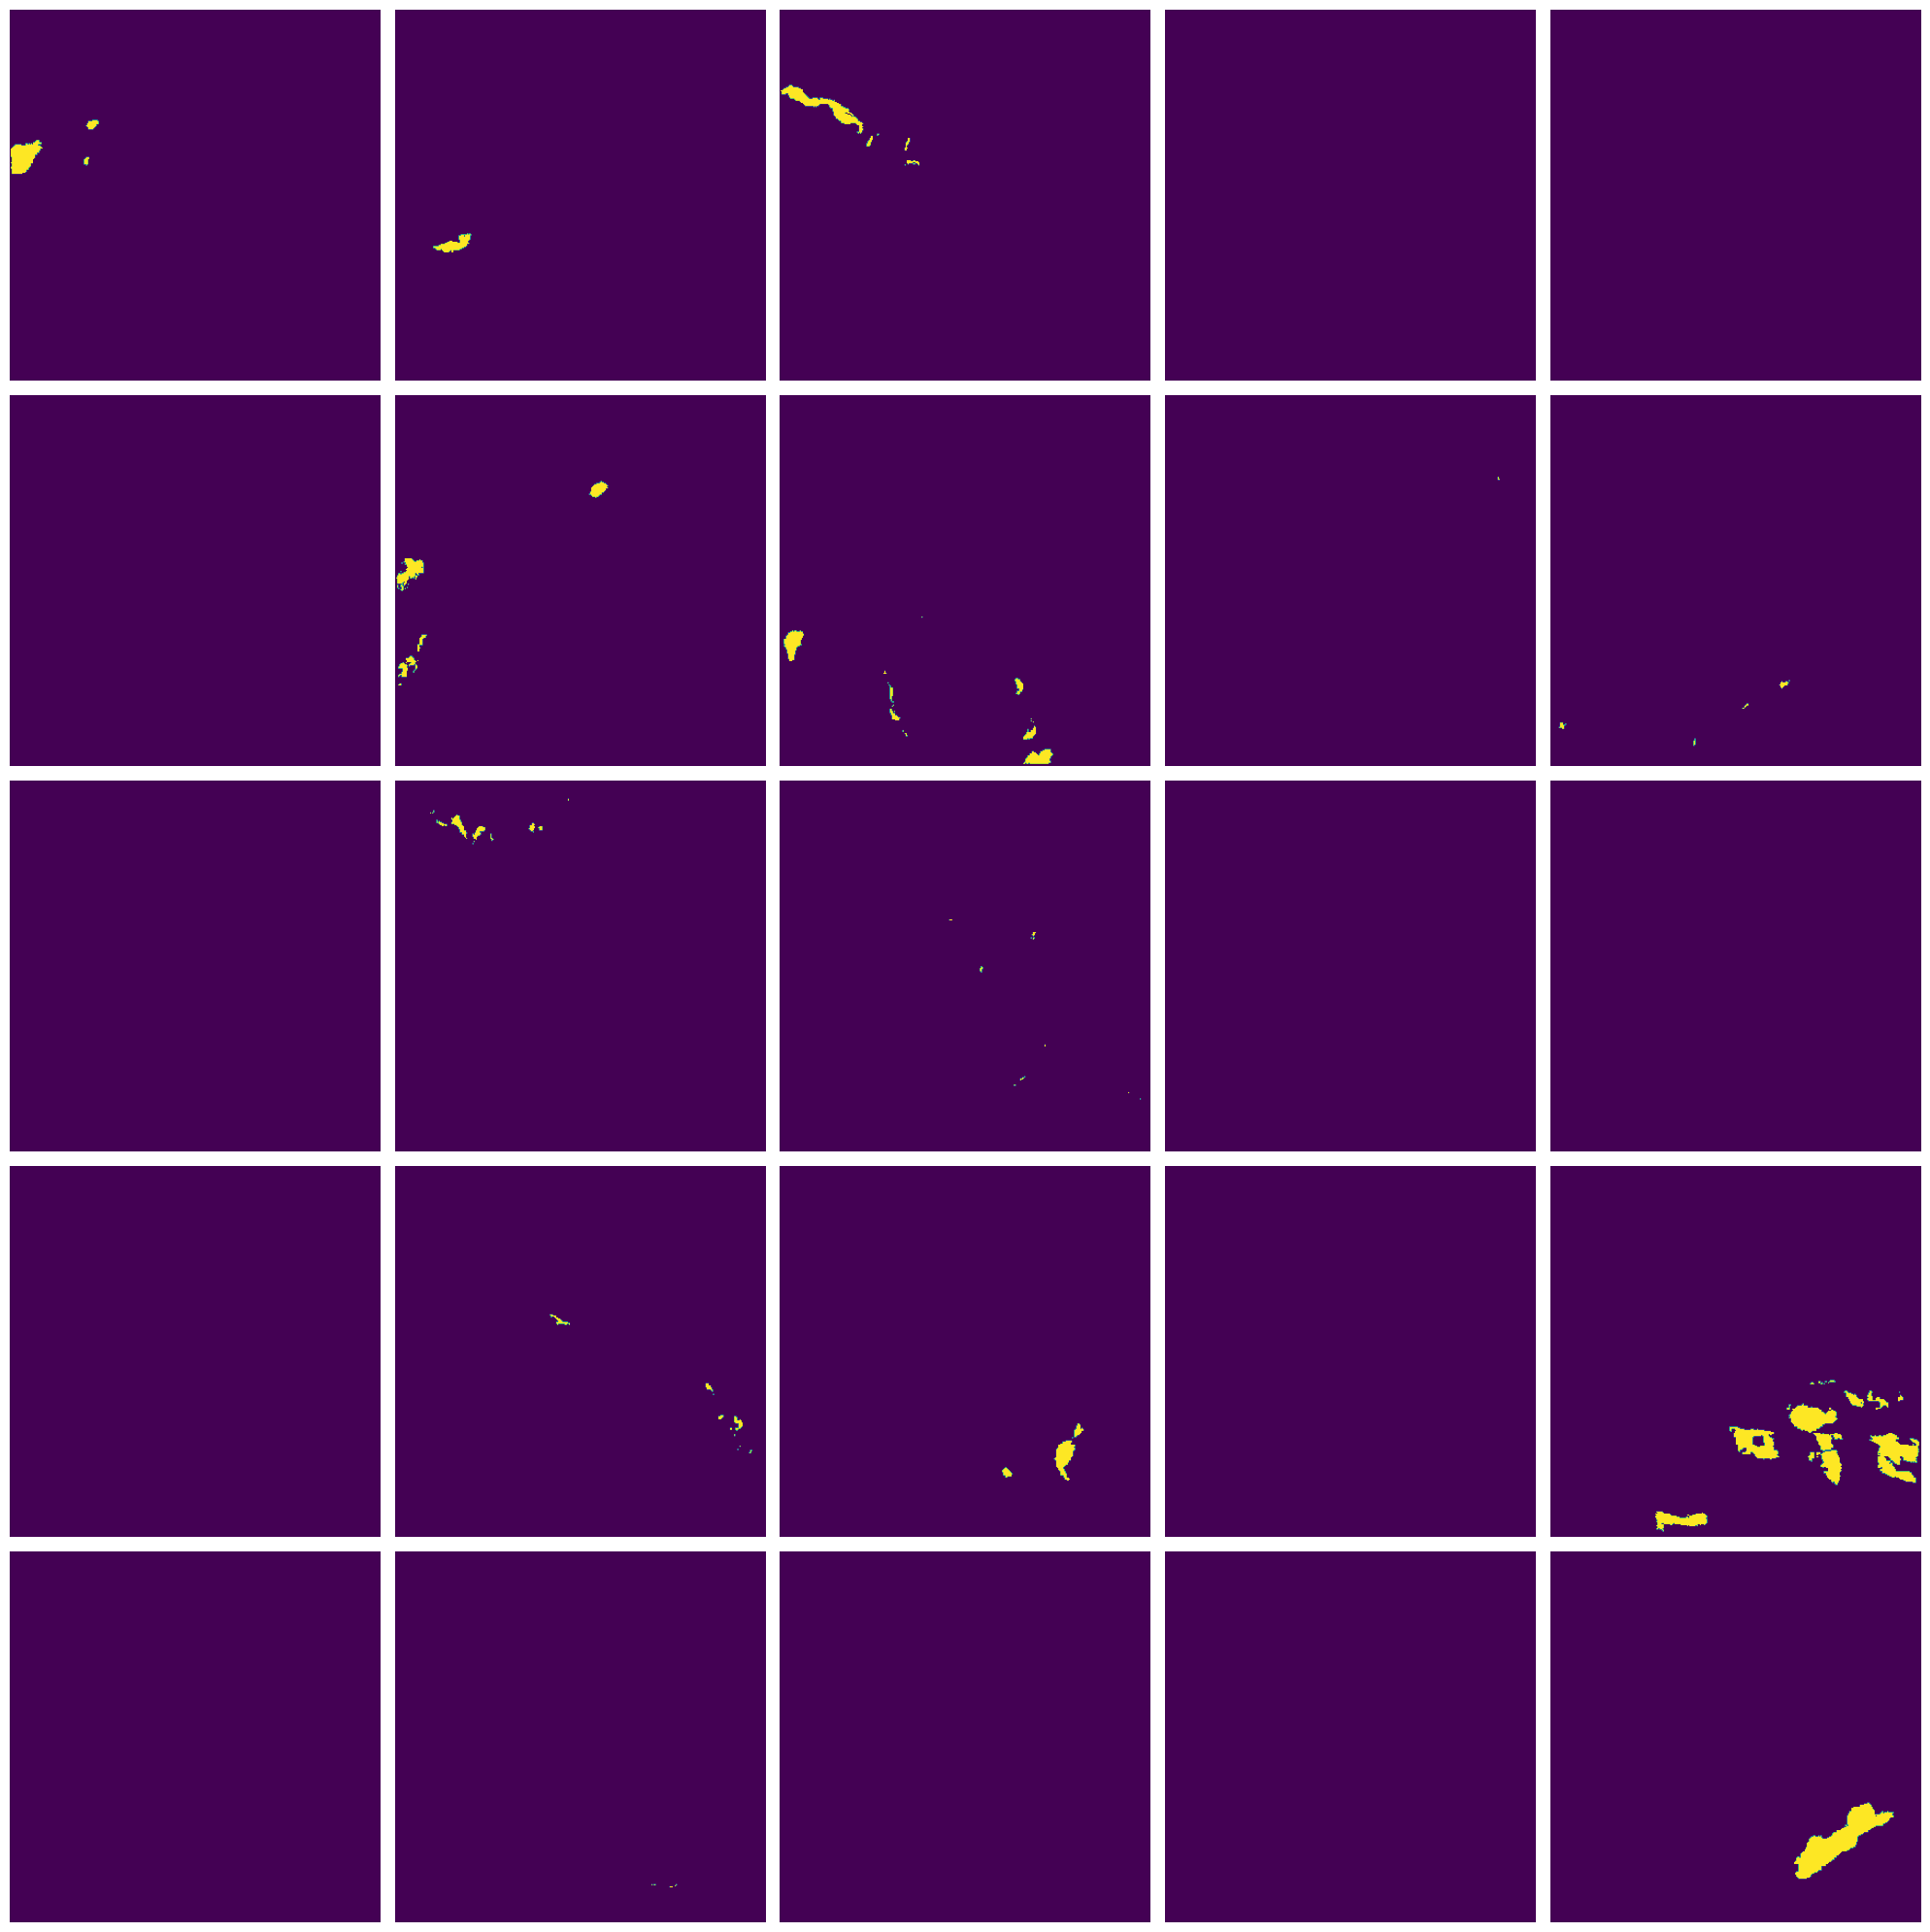

In [14]:
_, masks = next(iter(dm.train_dataloader()))

rows, cols = 5, 5
fig = plt.figure(figsize=(20, 20))
for i in range(25):
	fig.add_subplot(rows, cols, i+1)
	plt.imshow(masks[i])
	plt.axis('off')
plt.tight_layout()
plt.show()

In [21]:
import cv2
import numpy as np

# Assuming 'img' is your binary image
contours, _ = cv2.findContours(masks[0].numpy().astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [23]:
len(contours)

3

In [26]:

for cnt in contours:
	# Aspect Ratio
	x, y, w, h = cv2.boundingRect(cnt)
	aspect_ratio = float(w)/h
	
	print(aspect_ratio)

0.625
0.9375
1.3333333333333333


In [40]:
dm = DataModule(Dataset="DatasetFCIm", batch_size=1)
dm.setup()

data = []

for _, masks in tqdm(dm.train_dataloader()):
	if masks.sum() > 0:
		contours, _ = cv2.findContours(masks[0].numpy().astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
		for cnt in contours:
			# Aspect Ratio
			x, y, w, h = cv2.boundingRect(cnt)
			aspect_ratio = float(w)/h
			# # Circularity
			area = cv2.contourArea(cnt)
			perimeter = cv2.arcLength(cnt, True)
			circularity = 4*np.pi*(area/(perimeter*perimeter)) if perimeter != 0 else 0
			# Convexity and Solidity
			hull = cv2.convexHull(cnt)
			hull_area = cv2.contourArea(hull)
			solidity = float(area)/hull_area if hull_area != 0 else 0
			# Eccentricity
			moments = cv2.moments(cnt)
			mu20 = moments['mu20']
			mu02 = moments['mu02']
			mu11 = moments['mu11']
			numerator = 2*mu11
			denominator = mu20 - mu02
			if denominator > 0 and numerator <= denominator:
				eccentricity = np.sqrt(1 - (numerator / denominator))
			else:
				eccentricity = 0  # or some other value		
			data.append((aspect_ratio, circularity, solidity, eccentricity))


  0%|          | 0/4508 [00:00<?, ?it/s]

100%|██████████| 4508/4508 [00:27<00:00, 162.68it/s]


In [41]:
df = pd.DataFrame(data, columns=["aspect_ratio", "circularity", "solidity", "eccentricity"])
df

,aspect_ratio,circularity,solidity,eccentricity
0,1.875000,0.249570,0.654167,0.000000
1,1.333333,0.554879,0.827586,0.586315
2,1.000000,0.522168,0.810458,0.635127
3,0.666667,0.643029,1.000000,0.000000
4,1.000000,0.000000,0.000000,0.000000
...,...,...,...,...
27262,1.487179,0.221046,0.534992,1.730771
27263,0.320000,0.154641,0.601975,0.000000
27264,1.000000,0.000000,0.000000,0.000000
27265,0.684932,0.152081,0.514584,0.000000


In [39]:
df.describe()

,aspect_ratio,circularity,solidity,eccentricity
count,27267.000000,27267.000000,27267.000000,22571.000000
mean,1.247612,0.268649,0.503567,296.684833
std,0.789275,0.230199,0.359254,9013.290622
min,0.076923,0.000000,0.000000,0.000000
25%,0.818182,0.000000,0.000000,0.000000
50%,1.000000,0.252738,0.613472,0.818423
75%,1.500000,0.461129,0.802817,1.251750
max,13.000000,0.871465,1.000000,494303.466792


In [99]:
def eval2(model, device=0, mask_loss=False):
	# dm = DataModule(false_color=True, t=[4], val_trans={'Resize': {"height":384, 'width':384}})
	dm = DataModule(Dataset="DatasetFCIm", batch_size=1)
	dm.setup()
	model.eval()
	model.cuda(device)
	metric = torchmetrics.Dice()
	with torch.no_grad():
		pbar = tqdm(dm.val_dataloader(shuffle=True))
		for batch in pbar:
			x, _y = batch
			if mask_loss: x = x[...,:-1]
			y_hat = model(x.cuda(device))
			y_hat = torch.sigmoid(y_hat) > 0.5
			y_hat = y_hat.cpu()
			if y_hat.sum() > 0:
				img = y_hat[0,0].numpy().astype(np.uint8)
				fig.add_subplot(1, 1, 1)
				# io.imsave('kk/mask.png', y_hat[0,0].numpy())
				contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
				for i, cnt in enumerate(contours):
					# Aspect Ratio
					x, y, w, h = cv2.boundingRect(cnt)
					aspect_ratio = float(w)/h
					# limits = (df.aspect_ratio.mean() + 3*df.aspect_ratio.std(), df.aspect_ratio.mean() - 3*df.aspect_ratio.std())
					# if aspect_ratio < limits[1] or aspect_ratio > limits[0]:
					if aspect_ratio < df.aspect_ratio.min() or aspect_ratio > df.aspect_ratio.max():
						# remove contour from mask
						cv2.drawContours(img, [cnt], -1, 0, -1)
						continue
						# io.imsave(f'kk/mask_{i}.png', img*255)
					# Circularity
					area = cv2.contourArea(cnt)
					perimeter = cv2.arcLength(cnt, True)
					circularity = 4*np.pi*(area/(perimeter*perimeter)) if perimeter != 0 else 0
					# limits = (df.circularity.mean() + 3*df.circularity.std(), df.circularity.mean() - 3*df.circularity.std())
					# if circularity < limits[1] or circularity > limits[0]:
					if circularity < df.circularity.min() or circularity > df.circularity.max():
						cv2.drawContours(img, [cnt], -1, 0, -1)
						continue
					# Convexity and Solidity
					hull = cv2.convexHull(cnt)
					hull_area = cv2.contourArea(hull)
					solidity = float(area)/hull_area if hull_area != 0 else 0
					# limits = (df.solidity.mean() + 3*df.solidity.std(), df.solidity.mean() - 3*df.solidity.std())
					# if solidity < limits[1] or solidity > limits[0]:
					if solidity < df.solidity.min() or solidity > df.solidity.max():
						cv2.drawContours(img, [cnt], -1, 0, -1)
						continue
					# Eccentricity
					moments = cv2.moments(cnt)
					mu20 = moments['mu20']
					mu02 = moments['mu02']
					mu11 = moments['mu11']
					numerator = 2*mu11
					denominator = mu20 - mu02
					if denominator > 0 and numerator <= denominator:
						eccentricity = np.sqrt(1 - (numerator / denominator))
					else:
						eccentricity = 0  # or some other value
					# limits = (df.eccentricity.mean() + 3*df.eccentricity.std(), df.eccentricity.mean() - 3*df.eccentricity.std())
					# if eccentricity < limits[1] or eccentricity > limits[0]:
					if eccentricity < df.eccentricity.min() or eccentricity > df.eccentricity.max():
						cv2.drawContours(img, [cnt], -1, 0, -1)
				y_hat = torch.tensor(img).float().unsqueeze(0).unsqueeze(0)
			metric(y_hat.float(), _y.unsqueeze(1))
			pbar.set_description(f'Dice: {metric.compute().cpu().item():.5f}')

In [100]:
eval2(module, mask_loss=True)

  0%|          | 0/1127 [00:00<?, ?it/s]

Dice: 0.68159: 100%|██████████| 1127/1127 [00:41<00:00, 27.42it/s]


No veo que mejore nada